<a href="https://colab.research.google.com/github/sejeong-park/Energy_Consumption/blob/main/02_03%5B%EB%AF%B8%EC%99%84%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric

In [92]:
dataset=read_csv('household_power_consumption.txt',sep=';',header=0,low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]},index_col=['datetime'])

In [93]:
dataset.head(4)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0


In [94]:
def fill_missing(values):
  one_day=60*24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if isnan(values[row,col]):
        values[row, col]=values[row-one_day,col]

In [95]:
dataset.replace('?',nan,inplace=True)

In [96]:
dataset=dataset.astype('float32')

In [97]:
fill_missing(dataset.values)

In [98]:
values=dataset.values

In [100]:
dataset['sub_metering_4']=(values[:,0]*1000/60)-(values[:,4]+values[:,5]+values[:,6])

In [102]:
dataset.to_csv('household_power_consumption.csv')

In [101]:
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,43.099998
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.429993,4.0,0.0,0.0,0.0,15.766666
2010-11-26 20:59:00,0.944,0.000,240.000000,4.0,0.0,0.0,0.0,15.733334
2010-11-26 21:00:00,0.938,0.000,239.820007,3.8,0.0,0.0,0.0,15.633333


최근 전력 소비를 감안할 때 앞으로 한 주 동안 예상되는 전력소비

예측 모델이 향후 7일 동안 매일의 활성 전력 예측

문제의 프레임은 여러 예측 단계를 감안할 때 다단계 타임시리즈 예측 문제로 지칭

다중 입력 변수를 사용하는 모델-> 다변량 다단계 연속 전위 예측 모델

전력 소비의 관측-> 일일 합계로 다운 샘플링


In [103]:
from pandas import read_csv
dataset=read_csv('household_power_consumption.csv',header=0,infer_datetime_format=True,parse_dates=['datetime'],index_col=['datetime'])
#resample data to daily
daily_groups=dataset.resample('D')
daily_data=daily_groups.sum()
#summarize
print(daily_data.shape)
print(daily_data.head())


(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


In [104]:
daily_data.to_csv('household_power_consumption_days.csv')
daily_data=daily_data.astype('float32')

예측은 7개의 값으로 구성-> 일주일동안 매일 하나씩


In [105]:
from numpy import split
from numpy import array
from pandas import read_csv

In [106]:
#예측 평가
def evaluate_forecasts(actual,predicted):
  scores=list()
  #calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    #calculate mse
    mse=mean_squared_error(actual[:,i],predicted[:,i])
    #calculate rmse
    rmse=sqrt(mse)
    #store
    scores.append(rmse)
  #calculate overall RMSE
  s=0
  for row in range(actual.shape[0]):
    for col in range(actural.shape[1]):
      s+=(actual[row,col]-predicted[row,col])**2
  score=sqrt(s/(actual.shape[0]*actual.shape[1]))
  return score,scores
                    


In [107]:
#split a univariate dataset into train.test sets
def split_dataset(data):
  #split into standard weeks
  train,test=data[1:-328],data[-328:-6]
  #restructure into window of weekly data
  train=array(split(train,len(train)/7))
  test=array(split(test,len(test)/7))
  return train, test

In [108]:
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766666
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733334
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


테스트 데이터와 트레이닝 데이터로 분할하기 

In [134]:
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [135]:
dataset=read_csv('household_power_consumption_days.csv',header=0,infer_datetime_format=True,parse_dates=['datetime'],index_col=['datetime'])
dataset=daily_data.astype('float32')
train, test = split_dataset(dataset.values)
#validate train data
print(train.shape)
print(train[0,0,0],train[-1,-1,0])
#validate test
print(test.shape)
print(test[0,0,0],test[-1,-1,0])

(159, 7, 8)
3390.46 1309.268
(46, 7, 8)
2083.454 2197.006


예제를 실행하면 트레인 데이터 159주의 데이터와 테스트 데이터 46주


In [136]:
#모델 평가
#evaluate_forcasts

def evaluate_mode(model_func,train,test):
  #history is a list of weekly data
  history=[x for x in train]
  #walk-forward validation over each week
  predictions=list()
  for i in range(len(test)):
    #predict the week
    yhat_sequence=model_func(history)
    #store the predictions
    predictions.append(yhat_sequence)
    #get real observation and add to history for predicting the next week
    history.append(test[i,:])
  predictions=array(predictions)
  #evaluate predictions days for each week
  score,scores=evaluate_forecasts(test[:,:,0],predictions)
  return score, scores


In [137]:
#summarize scores-> 모델의 성능을 단일 라인으로 표시하여 다른 모델과 쉽게 비교
def summarize_scores(name, score,scores):
  s_scores=','.join(['%.1f'%s for s in scores])


to_series 함수는 Weekly 창으로 나눈 다변량 데이터를 가져와서 단일 시계열을 변환한다. 

In [149]:
#convert windows of weekly multivariate data into a series of total power
def to_series(data):
  #extract just the total power from each week
  series=[week[:,0] for week in data]
  #flatten into a single series
  series=array(series).flatten()
  return series

In [150]:
#일일 전력 소비 데이터 집합 로드
dataset=read_csv('household_power_consumption_days.csv',header=0,infer_datetime_format=True,parse_dates=['datetime'],index_col=['datetime'])

In [151]:
#다시 일일 전력 소비 데이터를 로드한거
#train, test 데이터 셋으로 분할
train, test=split_dataset(dataset.values)

In [152]:
#트레인 데이터에서 일변수 시계열 시리즈 추출
#convert training data into a series
series=to_series(train)

# 자기 회귀 패턴 PLOT

ACF : 지연이 증가함에 따라 서서히 저하되는 다수의 중요한 지여 관측치

PACF : 지연이 증가함에 따라 갑자기 떨어지는 몇 가지 중요한 지연 관측치


<Figure size 432x288 with 0 Axes>

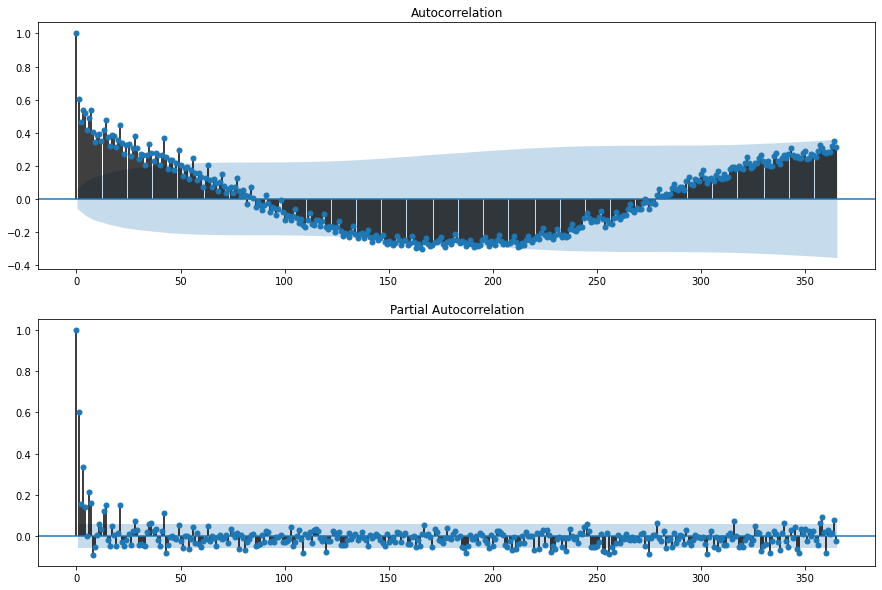

In [156]:
#plot

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
#lag는 지연 관측치
lags=365

plt.figure(figsize=(15,10))

#acf
axis=pyplot.subplot(2,1,1)
plot_acf(series,ax=axis,lags=lags)
#pacf
axis=pyplot.subplot(2,1,2)
plot_pacf(series,ax=axis,lags=lags)
#show plot
pyplot.show()

PLOT 을 확대하고 지연 관찰 수를 365에서 50으로 변경

<Figure size 432x288 with 0 Axes>

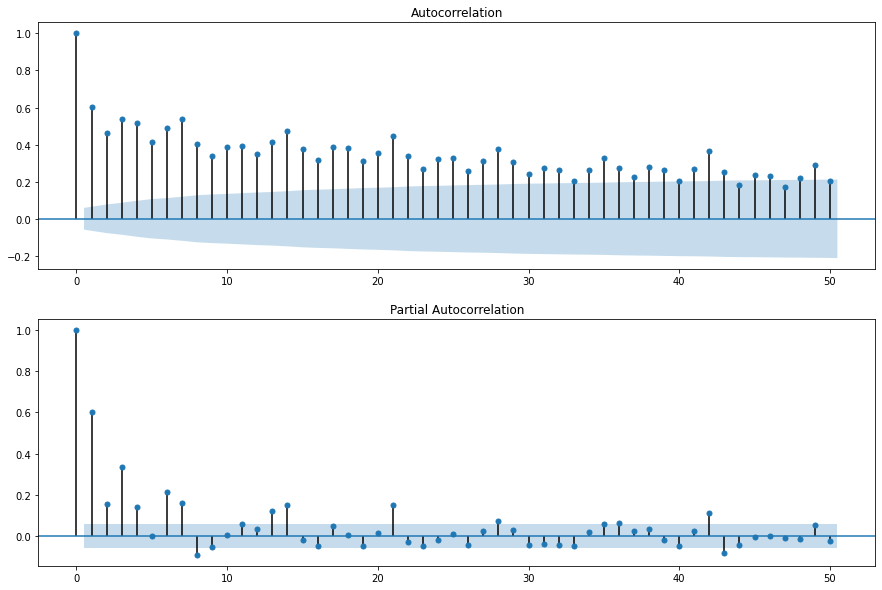

In [157]:
#plot

pyplot.figure()
lags=50

plt.figure(figsize=(15,10))

#acf
axis=pyplot.subplot(2,1,1)
plot_acf(series,ax=axis,lags=lags)
#pacf
axis=pyplot.subplot(2,1,2)
plot_pacf(series,ax=axis,lags=lags)
#show plot
pyplot.show()

**일일 전력 소비의 일변량 시리즈에 대한 자기 회귀 모델 개발**

Sratemodels 라이브러리는 AR,ARMA,ARIMA, SARIMA 클래스 사용과 같은 AR 모델 개발 여러 방법 제공

ARIMA 구현을 통해 차이 및 이동 평균 확장


In [12]:
from statsmodels.tsa.arima_model import ARIMA

In [172]:


# arima forecast
def arima_forecast(history):
	# convert history into a univariate series
	series = to_series(history)
	# define the model
	model = ARIMA(series, order=(7,0,0))
	# fit the model
	model_fit = model.fit()
	# make forecast
	yhat = model_fit.predict(len(series), len(series)+6)
	return yhat

In [158]:
#몇 주 동안 과거 관찰로 구성된 히스토리 데이터-> 일일 전력 소비의 일변량 시계열 데이터로 변환
#convert history into a univariate series
series=to_series(history)

NameError: ignored

arima: [381.645] 393.8, 398.9, 357.0, 377.2, 393.9, 306.0, 432.2


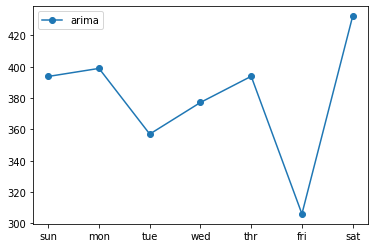

In [13]:

# arima forecast
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series
 
# arima forecast
def arima_forecast(history):
	# convert history into a univariate series
	series = to_series(history)
	# define the model
	model = ARIMA(series, order=(7,0,0))
	# fit the model
	model_fit = model.fit()
	# make forecast
	yhat = model_fit.predict(len(series), len(series)+6)
	return yhat
 
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()\







   

    
pyplot.show()